# Transfer learning and Fine-tuning with ConvNeXt model

## Import libraries and suppressing of warnings

In [ ]:
# ConvNeXt model available from version 2.11
!pip install tensorflow --upgrade

In [21]:
!pip install split-folders
import splitfolders

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import shutil

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Random seed for reproducibility
seed = 22

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.6.4


In [2]:
labels = [
    "Species1",  #1
    "Species2",  #2
    "Species3",  #3
    "Species4",  #4
    "Species5",  #5
    "Species6",  #6
    "Species7",  #7
    "Species8",  #8
]

## Dataset splitting

In [24]:
dataset_dir = './dataset'

if not(os.path.exists(dataset_dir)) :
    print('splitting dataset')
    
    splitfolders.fixed("../input/an2dl-data/training_data_final", 
                       output="dataset",
                       seed=seed, 
                       fixed=(35),
                       oversample=False, 
                       group_prefix=None, 
                       move=False)

# Setting dataset directories
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

splitting dataset


Copying files: 3542 files [00:20, 170.03 files/s]


In [3]:
# To count the images per class
def count_dir_files(dir):
    count_dir = {}
    for sp in labels:
        count_dir[sp] = len(os.listdir(dir+sp))

    return count_dir

In [26]:
# This function is used for oversampling. It creates augmented copies of the images
def augm_img(dir_noaug,dir_aug,image_generator_train, img_cnt, labels):
    
    # Create a new directory and copy into it the content of the one splitted
    shutil.copytree('./'+dir_noaug, './'+dir_aug)
    
    count_dict = count_dir_files('./'+dir_noaug+'/train/')
    
    for lab in labels:
        count_to_reach = img_cnt - count_dict[lab]
        fin_iter = 0
        iterations = int(count_to_reach / count_dict[lab])
        if count_to_reach > count_dict[lab]:
            partial_tot = iterations*count_dict[lab]
            
            fin_iter = count_to_reach - partial_tot

        elif count_to_reach < count_dict[lab]:
            fin_iter = count_to_reach
        
        data_gen_spec = image_generator_train.flow_from_directory(directory='./'+dir_noaug+'/train',
                                                                  target_size = (96,96),
                                                                  color_mode = 'rgb',
                                                                  classes=[lab],
                                                                  batch_size=count_dict[lab],
                                                                  shuffle = True,
                                                                  save_to_dir='./'+dir_aug+'/train/'+lab,
                                                                  save_format='jpg',
                                                                  save_prefix="augmented")

        for i in range(iterations):
            data_gen_spec.next()
            
        if fin_iter != 0:
            data_gen_spec = image_generator_train.flow_from_directory(directory='./'+dir_noaug+'/train',
                                                                      target_size = (96,96),
                                                                      color_mode = 'rgb',
                                                                      classes=[lab],
                                                                      batch_size=fin_iter,
                                                                      shuffle = True,
                                                                      save_to_dir='./'+dir_aug+'/train/'+lab,
                                                                      save_format='jpg',
                                                                      save_prefix="augmented")
            data_gen_spec.next()

In [27]:
#Image Generator For Augmetation
image_generator_aug = ImageDataGenerator(rotation_range=90, 
                                         width_shift_range=0.3,
                                         height_shift_range=0.3,
                                         horizontal_flip=True,
                                         brightness_range=(0.7,1.1),
                                         vertical_flip=True,
                                         zoom_range=0.1, 
                                         fill_mode='reflect')

In [4]:
dataset_dir="./datasetAug"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [29]:
# We augmented all images until we reach 3000 images per class
augm_img('dataset','datasetAug',image_generator_aug, 3000, labels)

Found 151 images belonging to 1 classes.
Found 151 images belonging to 1 classes.
Found 497 images belonging to 1 classes.
Found 497 images belonging to 1 classes.
Found 480 images belonging to 1 classes.
Found 480 images belonging to 1 classes.
Found 476 images belonging to 1 classes.
Found 476 images belonging to 1 classes.
Found 496 images belonging to 1 classes.
Found 496 images belonging to 1 classes.
Found 187 images belonging to 1 classes.
Found 187 images belonging to 1 classes.
Found 502 images belonging to 1 classes.
Found 502 images belonging to 1 classes.
Found 473 images belonging to 1 classes.
Found 473 images belonging to 1 classes.


In [5]:
count_dir_files(dataset_dir+"/train/")

{'Species1': 3000,
 'Species2': 3000,
 'Species3': 3000,
 'Species4': 3000,
 'Species5': 3000,
 'Species6': 2999,
 'Species7': 3000,
 'Species8': 3000}

## Load dataset with ImageDataGenerator

In [6]:
image_generator_preprocessing = ImageDataGenerator()

train_data = image_generator_preprocessing.flow_from_directory(training_dir,
                                                       target_size = (96,96),
                                                       color_mode = 'rgb',
                                                       classes = None,
                                                       batch_size = 64,
                                                       shuffle = True,
                                                       seed = seed)

validation_data = image_generator_preprocessing.flow_from_directory(validation_dir,
                                                                 target_size = (96,96),
                                                                 color_mode = 'rgb',
                                                                 classes = None,
                                                                 batch_size = 64,
                                                                 shuffle = False,
                                                                 seed = seed)

Found 23999 images belonging to 8 classes.
Found 280 images belonging to 8 classes.


## Definition of the Fully connected part

In [8]:
input_shape = (96, 96, 3)

dropoutrate = 0.35
elastic_lambda = 5e-4
learning_rate = 5e-4

In [33]:
# Load the base version of the ConvNeXt model pre-downloaded with 96x96x3 as input size
supernet = tfk.applications.ConvNeXtBase(include_top=False,
                                         weights="imagenet",
                                         input_shape=input_shape)

supernet.trainable = False

In [35]:
input_layer = tfk.Input(shape=input_shape,name="input_layer")

x = supernet(input_layer) 

x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)

x = tfkl.BatchNormalization()(x)

classifier_layer1 = tfkl.Dense(units=128,
                               name='Classifier1', 
                               activation=tfkl.LeakyReLU(),
                               kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda),
                               kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              )(x)
    
classifier_layer1 = tfkl.Dropout(dropoutrate, seed=seed)(classifier_layer1)

output_layer = tfkl.Dense(units=8,
                          name='output_layer',
                          activation='softmax',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          )(classifier_layer1)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
convnext_base (Functional)   (None, 3, 3, 1024)        87566464  
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
Classifier1 (Dense)          (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 8)                 1032  

## Transfer Learning

In [9]:
callbacks = []
# Early Stopping
# --------------
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=12, 
                                               restore_best_weights=True)
callbacks.append(es_callback)

# ReduceLROnPlateau
# -----------------
red_lr_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5,factor=0.3)
callbacks.append(red_lr_callback)

In [37]:
# Train the model
history = model.fit(
    x = train_data,
    epochs = 100,
    validation_data = validation_data,
    callbacks = callbacks,
    verbose=2,
).history
print("END TRAINING")

Epoch 1/100
375/375 - 77s - loss: 3.1273 - accuracy: 0.6637 - val_loss: 2.5043 - val_accuracy: 0.7429
Epoch 2/100
375/375 - 60s - loss: 2.1393 - accuracy: 0.7776 - val_loss: 1.8592 - val_accuracy: 0.7929
Epoch 3/100
375/375 - 60s - loss: 1.5590 - accuracy: 0.8001 - val_loss: 1.3769 - val_accuracy: 0.7929
Epoch 4/100
375/375 - 60s - loss: 1.2116 - accuracy: 0.8079 - val_loss: 1.1924 - val_accuracy: 0.7750
Epoch 5/100
375/375 - 60s - loss: 1.0487 - accuracy: 0.8079 - val_loss: 1.0864 - val_accuracy: 0.7679
Epoch 6/100
375/375 - 60s - loss: 0.9845 - accuracy: 0.8052 - val_loss: 1.0132 - val_accuracy: 0.7964
Epoch 7/100
375/375 - 60s - loss: 0.9469 - accuracy: 0.8043 - val_loss: 0.9926 - val_accuracy: 0.8036
Epoch 8/100
375/375 - 60s - loss: 0.9230 - accuracy: 0.8058 - val_loss: 0.9917 - val_accuracy: 0.7964
Epoch 9/100
375/375 - 60s - loss: 0.9083 - accuracy: 0.8087 - val_loss: 0.9431 - val_accuracy: 0.8107
Epoch 10/100
375/375 - 60s - loss: 0.8983 - accuracy: 0.8072 - val_loss: 0.9954 - 

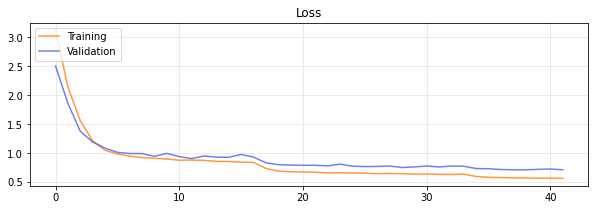

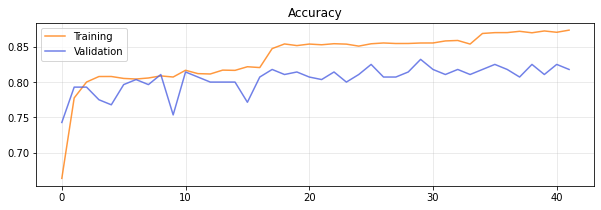

In [38]:
# Plot the training

plt.figure(figsize=(10,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

plt.figure(figsize=(10,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [11]:
name="ConvNeXt_base_tl"

In [40]:
model.save(name)
del model

## Fine Tuning

In [12]:
model = tfk.models.load_model('./'+name)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
convnext_base (Functional)   (None, 3, 3, 1024)        87566464  
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
Classifier1 (Dense)          (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 8)                 1032  

In [14]:
model.get_layer(index=1).trainable = True

for i, layer in enumerate(model.get_layer(index=1).layers):
   print(i, layer.name, layer.trainable)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
convnext_base (Functional)   (None, 3, 3, 1024)        87566464  
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
Classifier1 (Dense)          (None, 128)               131200    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 8)                 1032  

In [16]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
              optimizer=tfk.optimizers.Adam(2e-5), 
              metrics='accuracy')

history = model.fit(
    x = train_data,
    epochs = 100,
    validation_data = validation_data,
    callbacks = callbacks,
    verbose = 2
).history

Epoch 1/100
375/375 - 203s - loss: 0.4940 - accuracy: 0.9050 - val_loss: 0.6194 - val_accuracy: 0.8643
Epoch 2/100
375/375 - 170s - loss: 0.3163 - accuracy: 0.9670 - val_loss: 0.5695 - val_accuracy: 0.9036
Epoch 3/100
375/375 - 170s - loss: 0.2421 - accuracy: 0.9892 - val_loss: 0.5468 - val_accuracy: 0.9143
Epoch 4/100
375/375 - 170s - loss: 0.2027 - accuracy: 0.9975 - val_loss: 0.5176 - val_accuracy: 0.9107
Epoch 5/100
375/375 - 170s - loss: 0.1809 - accuracy: 0.9992 - val_loss: 0.5143 - val_accuracy: 0.9143
Epoch 6/100
375/375 - 170s - loss: 0.1654 - accuracy: 0.9997 - val_loss: 0.5279 - val_accuracy: 0.9179
Epoch 7/100
375/375 - 170s - loss: 0.1532 - accuracy: 0.9997 - val_loss: 0.5034 - val_accuracy: 0.9179
Epoch 8/100
375/375 - 170s - loss: 0.1414 - accuracy: 0.9999 - val_loss: 0.5132 - val_accuracy: 0.9179
Epoch 9/100
375/375 - 170s - loss: 0.1298 - accuracy: 0.9999 - val_loss: 0.5170 - val_accuracy: 0.9071
Epoch 10/100
375/375 - 170s - loss: 0.1182 - accuracy: 1.0000 - val_loss:

# Evaluation Of the Model

PRINT MODEL STATS:


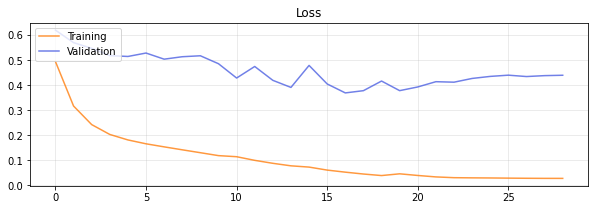

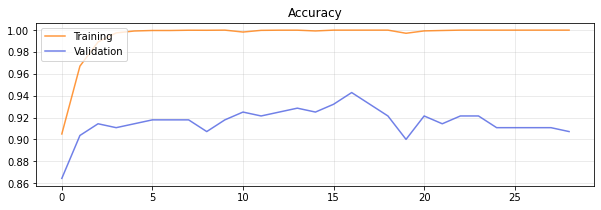

In [17]:
# Plot the training
print("PRINT MODEL STATS:")
plt.figure(figsize=(10,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

plt.figure(figsize=(10,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


PLOTTING NEW MODEL:

Confusion Matrix
[[30  3  1  0  0  0  0  1]
 [ 0 33  0  0  0  0  0  2]
 [ 0  0 35  0  0  0  0  0]
 [ 0  0  1 34  0  0  0  0]
 [ 0  0  0  3 32  0  0  0]
 [ 0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0 33  2]
 [ 1  0  1  1  0  0  0 32]]


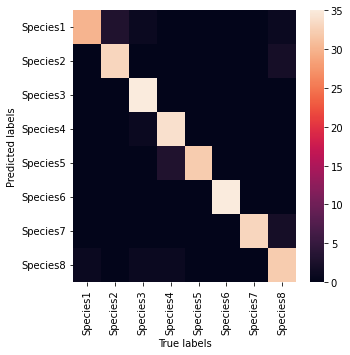



5/5 [==============================] - 1s 142ms/step - loss: 0.3687 - accuracy: 0.9429

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        35
           1       0.92      0.94      0.93        35
           2       0.92      1.00      0.96        35
           3       0.89      0.97      0.93        35
           4       1.00      0.91      0.96        35
           5       1.00      1.00      1.00        35
           6       1.00      0.94      0.97        35
           7       0.86      0.91      0.89        35

    accuracy                           0.94       280
   macro avg       0.95      0.94      0.94       280
weighted avg       0.95      0.94      0.94       280



In [19]:
print("\nPLOTTING NEW MODEL:\n")
Y_pred = model.predict(validation_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_data.classes, y_pred);
print(cm)
plt.figure(figsize=(5,5))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

print("\n")
metrics = model.evaluate(validation_data, return_dict=True)
print()
print(classification_report(validation_data.classes, y_pred))

In [20]:
model.save('ConvNeXt_base_ft')